# Data Reduction and Photometry:

This lab begins the process of reducing the observing project and using photometry techniques to analyze it. 

### 1: Bias and Overscan

__Define the bias. Include both a description of what it looks like physically, why it
occurs, and how we take it into account (how do we remove its effect on our data
images?) Your data is from the ARCTIC instrument - it has two modes (one amplifier read
out or four amplifier read out).__

The bias is the readout of the ccd when it hasn't been exposed to any light. The results of this readout shows that the amplifier has been set to some offset voltage inorder to avoid negative numbers while taking an actual image. What it looks like physically is the entire ccd exposed to light that is very uniform. The noise in a bias scan comes from the electrinics alone. This can be seen below. To take the bias into account

In [1]:
from astropy.nddata import CCDData
from astropy.visualization import hist
from pathlib import Path
from astropy.stats import mad_std

import astropy.io.fits as fits
import glob
import ccdproc as ccdp
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import astropy.stats as stats


In [2]:
def imagePreview(path, vMin = 5, vMax = 99.7):
    """
    Function that creates plots of all data from fits files at the end of the path passed
    Useful for visual inspection of the data
    """
    fileNames = glob.glob(path)
    openFits = [ fits.open(a) for a in fileNames]

    data = [a[0].data for a in openFits]
    fig, ax = plt.subplots(len(fileNames), 1, figsize= (8,8*len(fileNames)) )

    for i in range(len(fileNames)):
        ax[i].imshow(data[i], vmin=np.percentile(data[i], vMin), vmax=np.percentile(data[i], vMax),
                   origin='lower', cmap='binary_r', interpolation='nearest')


In [ ]:
imagePreview('data/CrabData/CrabNebula*.fits')

__Why would we use more than one bias frame__

The purpose of combining many bias' is to reduce the read noise in the combined bias.

The first step will be to fix the headers so that they can actually be read in.

In [ ]:
fileNames = glob.glob('data/bias*.fits')
imageData = [fits.open(a) for a in fileNames]

headers = [a[0].header for a in imageData]
for a in headers:
    del a['CD1_1']
    del a['CD1_2']
    del a['CD2_1']
    del a['CD2_2']

In [ ]:
for a in range(len(fileNames)):
    image = imageData[a]
    fits.writeto('data/trimmed_bias/fixedBias.000{0}.fits'.format(a), image[0].data, headers[a], overwrite = True)

Ok Cool, now it looks like these images need to have the overscan trimmed off. That is clear from the columns BSECxx above that show where the overscan regions are.  

Here 

Excellent, now that the functions exist to take off the overscan, I can begin combining the bias images to make a master bias. For this section I decided to write my own function since the one's in ccdproc weren't accomplishing what I was expecting
The method used here is sigma clipping the initial images and then combining by average. 

In [ ]:
# To do this I will need an additional import: 


In [ ]:
files =  glob.glob('data/trimmed_bias/trimmed*.fits')
data = [fits.getdata(a) for a in files]

clipped = stats.sigma_clip(data[0], sigma = 3, maxiters = 1, 
                          cenfunc = np.ma.median, stdfunc = mad_std)

In [ ]:
for a in data: 
    print(a.min(), a.max(), a.mean(), a.std())
    
clipped = [stats.sigma_clip(a, sigma = 3, maxiters = 1,
                           cenfunc = np.ma.median, stdfunc = mad_std) for a in data]

for a in clipped:
    print(a.min(), a.max(), a.mean(), a.std())

In [ ]:
average = np.average(clipped, axis = 0)

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (16,8))

ax[1].imshow(average, vmin=np.percentile(average, 5), vmax=np.percentile(average, 99.7),
                   origin='lower', cmap='binary_r', interpolation='nearest');
ax[0].imshow(data[0], vmin=np.percentile(data[0], 5), vmax=np.percentile(data[0], 99.7),
                   origin='lower', cmap='binary_r', interpolation='nearest');

This seems like it's worked. Now I'll save this as a new file and move onto the rest of the bias lab.

In [ ]:
hdu = fits.PrimaryHDU(average)
hdu.writeto('data/trimmed_bias/combinedBias.fits')

To subtract the bias I am simply going to subtract it from the other images as there seems to be no "defined" way of doing this

In [ ]:
crabFiles = glob.glob('data/CrabData/trimmedCrabData/*')
crabData = [fits.getdata(a) for a in crabFiles]
headers = [fits.getheader(a) for a in crabFiles]

for a in (crabData):
    a = a - average
    
for i, a in enumerate(crabData):
    fits.writeto('data/CrabData/trimmedCrabData/01reducedCrabNebula.000{0}.fits'.format(i),
                a, headers[i], overwrite = True)

In [ ]:
imagePreview('data/CrabData/trimmedCrabData/01reducedCrabNebula*fits') # Subtracts the bias and resaves the images

__Define the overscan__  
I believe that the overscan is a section of bias image that is added to every image. It is digitally added and so does not represent physical pixels on the chip. It is useful for detecting changes in the state of the CCD as the image taking is happening as most of the time bias frames are taken before or after an imaging run. 

In [ ]:
# Removing the overscan is already done. 

__List the overscan parameters__  
The overscan for these images according to the headers is between 1029 and 1074 inclusive and 0 to 2050. However when trimming the overscan from the image it was necessary to trim more than what was listed. I ended up trimming the image from 1027 to 1077 and from 0 to 2050. 


### Flat Fielding
__Which filters do you have flat fields for? List the flat field file names for each
filter that you need. Do you have more flats than you need?__  

I have flats fields for the r, i, g, and z filters.

In [ ]:
path =  Path('data/flats')
files = ccdp.ImageFileCollection(path)
zfilter =  files.filter(filter = 'SDSS z')

For reducing using the flat fields, it is omportant to use flats with the same exposure time as the images. 

__Why do we need flat fields for each of the filters in our observations?__  

The reason for flat fields in each filter is to calibrate the response of the ccd for each filter band. CCD's have different efficencies for different wavelengths of light so must be calibrated for the different wavelengths.   

So now I will trim the overscan regions, and then subtract the bias from one set of filters

In [ ]:
def trimImages(files, writeName):
    """
    Trim image list of files. Doesn't matter where they came from. 
    """
    
    data = [fits.getdata(a) for a in files]
    headers = [fits.getheader(a) for a in files]
    
    colums = np.arange(1029,1074,1)
    rows = np.arange(1024, 1027, 1)
    for i, a in enumerate(data):
        a = np.delete(a, rows, 0)
        a = np.delete(a, colums, 1)
        fits.writeto(writeName.format(i),
                    a, headers[i], overwrite = True)

In [ ]:
# Plot the original bias' to compare to trimmed ones

imagePreview('data/flats/flat_z*.fits')

So the flat images don't match the science images in terms of where it  _looks_ like the overscan occurs. Taking this is some wierd display issue, I will continue with the flat calibration and will likely trim the science images to match the trimming done to the flats. 

In [ ]:
# Re trim the bias'
biass = glob.glob('data/trimmed_bias/fix*.fits')
writeName = 'data/trimmed_bias/trimmedBias.000{0}.fits'
trimImages(biass, writeName)
imagePreview('data/trimmed_bias/trimmed*')

In [ ]:
# Now recombining the bias' according to the new overscan dimensions

#Read in data 
files =  glob.glob('data/trimmed_bias/trimmed*.fits')
data = [fits.getdata(a) for a in files]

#Sigma clip the data
clipped = [stats.sigma_clip(a, sigma = 3, maxiters = 1,
                           cenfunc = np.ma.median, stdfunc = mad_std) for a in data]
# Get the average
average = np.average(clipped, axis = 0)

# Plot the average to visually inspect
fig, ax = plt.subplots(1,2, figsize = (16,8))

ax[1].imshow(average, vmin=np.percentile(average, 5), vmax=np.percentile(average, 99.7),
                   origin='lower', cmap='binary_r', interpolation='nearest');
ax[0].imshow(data[0], vmin=np.percentile(data[0], 5), vmax=np.percentile(data[0], 99.7),
                   origin='lower', cmap='binary_r', interpolation='nearest');

In [ ]:
# Save the combined provided it looks ok

hdu = fits.PrimaryHDU(average)
hdu.writeto('data/trimmed_bias/combinedBias.fits', overwrite = True)

In [ ]:
# Subtract the bias from the flats, 
# Get the zfilter data

path =  Path('data/flats')
files = ccdp.ImageFileCollection(path)
zfilter =  files.files_filtered(filter = 'SDSS z')
zfiles = zfilter.files

# Chop the overscan from the image
trimImages(zfiles, 'data/flats/trimmedFlats/flat_z.000{0}.fits')

#Subtract the combined bias from each of the flats

zfiles = glob.glob('data/flats/trimmedFlats/flat_z*.fits')
zdata = [fits.getdata(a) for a in zfiles]
zheader = [fits.getheader(a) for a in zfiles]

for i, a in enumerate(zdata):
    a = a - average
    fits.writeto('data/flats/reducedFlat_z.000{0}.fits'.format(i), a, zheader[i], overwrite =True)

In [ ]:
# Now make the above a function called subtract bias so that it can be called on all of the flats

def subtractBias(files, writeName, baisFile):
    """
    Subtract the bias from anything dog
    """
    biasData = fits.getdata(biasFile)
    
    data = [fits.getdata(a) for a in files]
    headers = [fits.getheader(a) for a in files] 
    
    for i, a in enumerate(data):
        a = a - biasData
        fits.writeto(writeName.format(i), a, headers[i], overwrite = True)

In [ ]:
# # Great now to just combine the images
# zfiles = glob.glob('data/flats/reduced*.fits')
# zdataObj = [CCDData.read(a, unit = 'adu') for a in zfiles]

def inv_median(a):
    return 1 / np.median(a)

# combined_flat = ccdp.combine(zdataObj,
#                                  method='average', scale=inv_median,
#                                  sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
#                                  sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
#                                  mem_limit=350e6
#                                 )

In [ ]:
combined_flat.write('data/flats/combinedZFlat.fits')

In [ ]:
# don't forget about the scale function
def combineFlats(files):
    
    dataObj = [CCDData.read(a, unit = 'adu') for a in files]
    
    combined_flat = ccdp.combine(dataObj,
                                 method='average', scale=inv_median,
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )
    return combined_flat

In [ ]:
# Now finally for the z filter we can use the flat correct function to correct the science images. 

#First I will retrim the science images and re-remove the bias

crabFiles = glob.glob('data/CrabData/Crab*.fits')
writeFile = 'data/CrabData/trimmedCrabData/trimmedCrabData.000{0}.fits'
trimImages(crabFiles, writeFile)

imagePreview('data/CrabData/trimmedCrabData/trimmed*.fits')

In [ ]:
# Now subtract the bias from them
files = glob.glob('data/CrabData/trimmedCrabData/trimmed*.fits')
writeFile = 'data/CrabData/trimmedCrabData/biasReducedCrabData.000{0}.fits'
biasFile = 'data/trimmed_bias/combinedBias.fits'
subtractBias(files, writeFile, biasFile)


In [ ]:
# Plotting science images with bias subtracted for reference
imagePreview('data/CrabData/reduced/biasReduced*.fits')

In [ ]:
# Now that the science images have had the overscan and bias subtracted we will use the flat correct function

zCombined = CCDData.read('data/flats/combinedZFlat.fits', unit = 'adu')

crabFiles = ccdp.ImageFileCollection('data/CrabData/reduced')
zFilter = crabFiles.filter(filter = 'SDSS z').files

zdata = [CCDData.read(a, unit = 'adu') for a in zFilter]

for i, a in enumerate(zdata):
    reduced = ccdp.flat_correct(a, zCombined)
    reduced.write('data/CrabData/reduced/reduced_zCrab.000{0}.fits'.format(i))

In [ ]:
imagePreview('data/CrabData/reduced/reduced_z*.fits')

1) Get the combined flat:  
   Get all the filters from that flat and trim them, 
   then use the subtract bias function to get the bias out of all of them
   then use the combine function to make a master flat  
   
2) Get the science images with the appropriate filters   
   Trim the science images
   Subtract the bias from the science images   
   
3) Use the flat_correct function to get the fully reduced science images.

In [4]:
# Now Reduce all of the images using their respective filters.

path =  Path('data/flats')
files = ccdp.ImageFileCollection(path)
filters = ['SDSS i', 'SDSS g#2', 'SDSS r#2']

# for a in filters:
#     filterFiles = files.files_filtered(include_path = True, filter = a)
    
#     # Chop the overscan from the chosen images
#     trimImages(filterFiles, 'data/flats/trimmedFlats/trimmedflat{0}.000{1}.fits'.format(a, '{0}'))

In [ ]:
biasFile = 'data/trimmed_bias/combinedBias.fits'
files = glob.glob('data/flats/trimmedFlats/trimmedflat*.fits')
writefile = 'data/flats/trimmedFlats/reducedFlat.000{0}.fits'

subtractBias(files, writefile, biasFile)
imagePreview('data/flats/trimmedFlats/reducedFlat*.fits')

In [ ]:
# pass the flats to be combined to to the combine flats function

files = ccdp.ImageFileCollection('data/flats/trimmedFlats/reducedFlat')
for a in filters: 
    current_filter = files.files_filtered(include_path = True, filter = a)
    combined_flat = combineFlats(current_filter)
    combined_flat.write('data/flats/combined{0}.fits'.format(a))

In [14]:
# Having already removed the bias all that is left is to use flat_correct to combine the images
flats = glob.glob('data/flats/combined*.fits')
flatfileCollection = ccdp.ImageFileCollection(filenames = flats)

crabData = glob.glob('data/CrabData/reduced/bias*.fits')
crabFileCollection = ccdp.ImageFileCollection(filenames = crabData)

for a in filters:
    combined_flat = flatfileCollection.filter(filter = a).files
    ccdCombinedFlat = CCDData.read(combined_flat[0], unit = 'adu')
    
    images = crabFileCollection.filter(filter = a).files
    ccdImages = [CCDData.read(a, unit = 'adu') for a in images]
    
    
    for u, j in enumerate(ccdImages):
        reduced = ccdp.flat_correct(j, ccdCombinedFlat)
        reduced.write('data/CrabData/reduced/reduced_{0}.000{1}.fits'.format(a, u), overwrite = True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/home/carter/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


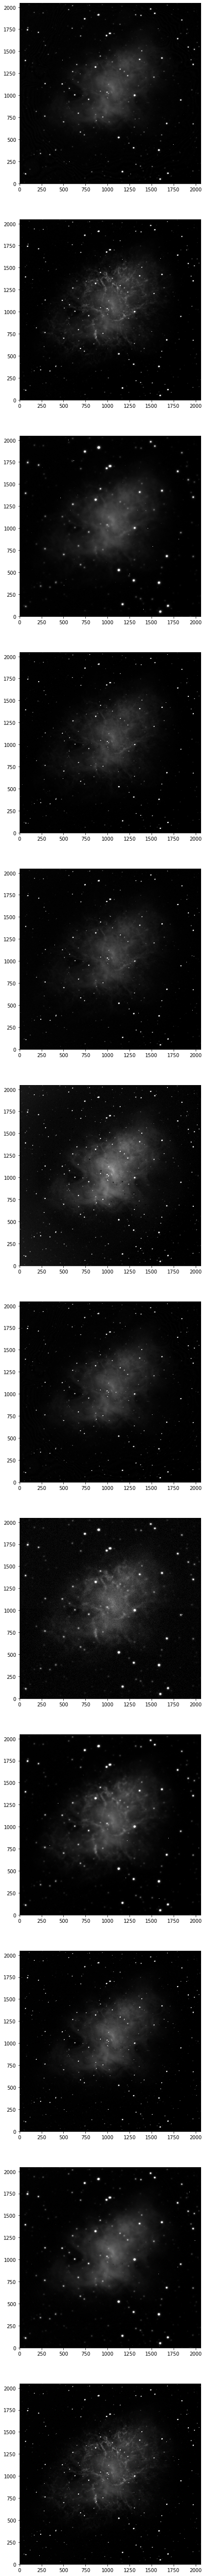

In [15]:
imagePreview('data/CrabData/reduced/reduced_*.fits')